#**Objective:** Create a hybrid model for stock price/performance prediction using numerical analysis of historical stock prices, and sentimental analysis of new headlines.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



####Importing the Python Liberaries to be used

In [2]:
!pip install pmdarima
!pip install --upgrade pandas_datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import datetime

#To import the dataset of a related stock from a particular link
import pandas_datareader.data as pdr
import yfinance as yf

#For evading warnings
import warnings
warnings.filterwarnings('ignore')

#For Numerical Analysis
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima
#from statsmodels.tsa.statespace.sarimax import SARIMAX

#For Textual(Sentiment) Analysis
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#Predicting Scores of Different Models
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score

#for scaling different Features
from sklearn.preprocessing import MinMaxScaler

#Different Models to evaluate
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
import lightgbm 
import xgboost

###Downloading and Importing the necessary Datasets

In [4]:
#Downloading SENSEX Stock data from the yahoo finance website for a specific duration
yf.pdr_override()
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime.today()
stock = pdr.get_data_yahoo('^BSESN', start, end)

[*********************100%***********************]  1 of 1 completed


In [5]:
#converting the stock_data file to CSV file
stock.to_csv('Stock_info.csv')

In [6]:
#importing the News dataset
news = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Stock Predictor/NewsHeadlines.csv')

###Data Cleaning

In [7]:
stock.sample(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-10-18,32518.560547,32670.320312,32462.849609,32584.349609,32584.349609,14100
2013-08-12,18898.939453,19066.970703,18796.009766,18946.980469,18946.980469,11700
2017-03-01,28849.039062,29029.169922,28824.169922,28984.490234,28984.490234,14600
2013-07-16,19788.089844,19890.630859,19649.580078,19851.230469,19851.230469,8000
2017-01-05,26738.419922,26917.210938,26738.419922,26878.240234,26878.240234,9800
2010-06-15,17355.490234,17442.500000,17249.460938,17412.830078,17412.830078,22400
2011-02-16,18273.060547,18358.839844,18216.119141,18300.900391,18300.900391,18800
2018-04-13,34167.531250,34313.140625,34103.531250,34192.648438,34192.648438,8300
2017-03-20,29653.539062,29699.480469,29482.400391,29518.740234,29518.740234,400800


In [8]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3304 entries, 2010-01-04 to 2023-06-09
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3304 non-null   float64
 1   High       3304 non-null   float64
 2   Low        3304 non-null   float64
 3   Close      3304 non-null   float64
 4   Adj Close  3304 non-null   float64
 5   Volume     3304 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 180.7 KB


**No NULL Entries** in the **stock** dataframe.


In [9]:
# Convert date that is the index of the dataframe to one of it's columns
stock.reset_index(inplace=True)

In [10]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3304 entries, 0 to 3303
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3304 non-null   datetime64[ns]
 1   Open       3304 non-null   float64       
 2   High       3304 non-null   float64       
 3   Low        3304 non-null   float64       
 4   Close      3304 non-null   float64       
 5   Adj Close  3304 non-null   float64       
 6   Volume     3304 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 180.8 KB


In [11]:
stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,17473.449219,17582.839844,17378.380859,17558.730469,17558.730469,28200
1,2010-01-05,17555.769531,17729.779297,17555.769531,17686.240234,17686.240234,27000
2,2010-01-06,17719.470703,17790.330078,17636.710938,17701.130859,17701.130859,21400
3,2010-01-07,17701.970703,17733.339844,17566.539062,17615.720703,17615.720703,18000
4,2010-01-08,17603.869141,17658.119141,17508.960938,17540.289062,17540.289062,17200


In [12]:
news.sample(10)

,publish_date,headline_category,headline_text
1817742,20140216,business.india-business,Letters to be sent to 23 lakh assessees for no...
2973532,20180830,city.kochi,Man arrested for seeking bribe from flood victim
3135202,20190601,city.indore,Couple jumps into river with 4-month-old son; ...
186140,20030218,calcutta-times,Straight Answers
2051838,20150118,city.delhi,Delhi's Janakpuri poll a fight for two worlds
1095473,20110402,city.hubballi,Hubli coffee shop turns stadium
654857,20081212,election-2008,Madhya Pradesh
3128973,20190520,city.udaipur,Lighting around Fateh Sagar Lake affects flora...
2972331,20180828,tv.news.hindi,Kumkum Bhagya written update; August 27; 2018:...
3507871,20210618,city.kochi,Greens worried over tree felling in Cardamom H...


In [13]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650970 entries, 0 to 3650969
Data columns (total 3 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   publish_date       int64 
 1   headline_category  object
 2   headline_text      object
dtypes: int64(1), object(2)
memory usage: 83.6+ MB


In [14]:
# Total unique headlines
news['headline_category'].unique().shape

(1041,)

In [15]:
#Checking no. of repeated/duplicated values in news
news.duplicated().sum()

24860

In [16]:
#Let's delete all the repeated news
news.drop_duplicates(inplace=True)

In [17]:
#installing Sweetiz library for data visualization
!pip install sweetviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


###Exploratory Data Analysis and Pre-Processing

####Textual Analysis

In [18]:
news['headline_category'].unique()

array(['unknown', 'entertainment.hindi.bollywood', 'india', ...,
       'sports.football.euro-2021', 'business.markets.ipo',
       'sports.tokyo-olympics.india-in-tokyo'], dtype=object)

In [19]:
# checking how many unique main headline categories are there
news['category'] = news['headline_category'].str.split('.',expand = True)[0]

                                             |          | [  0%]   00:00 -> (? left)


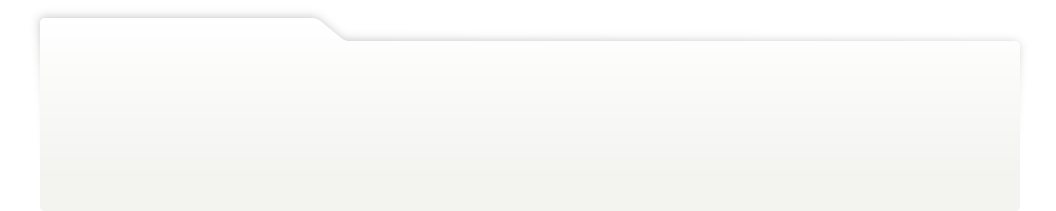
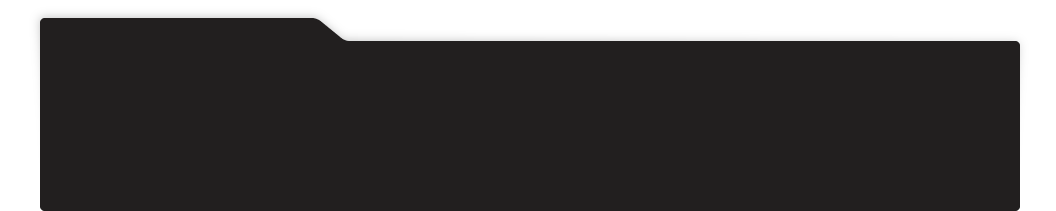
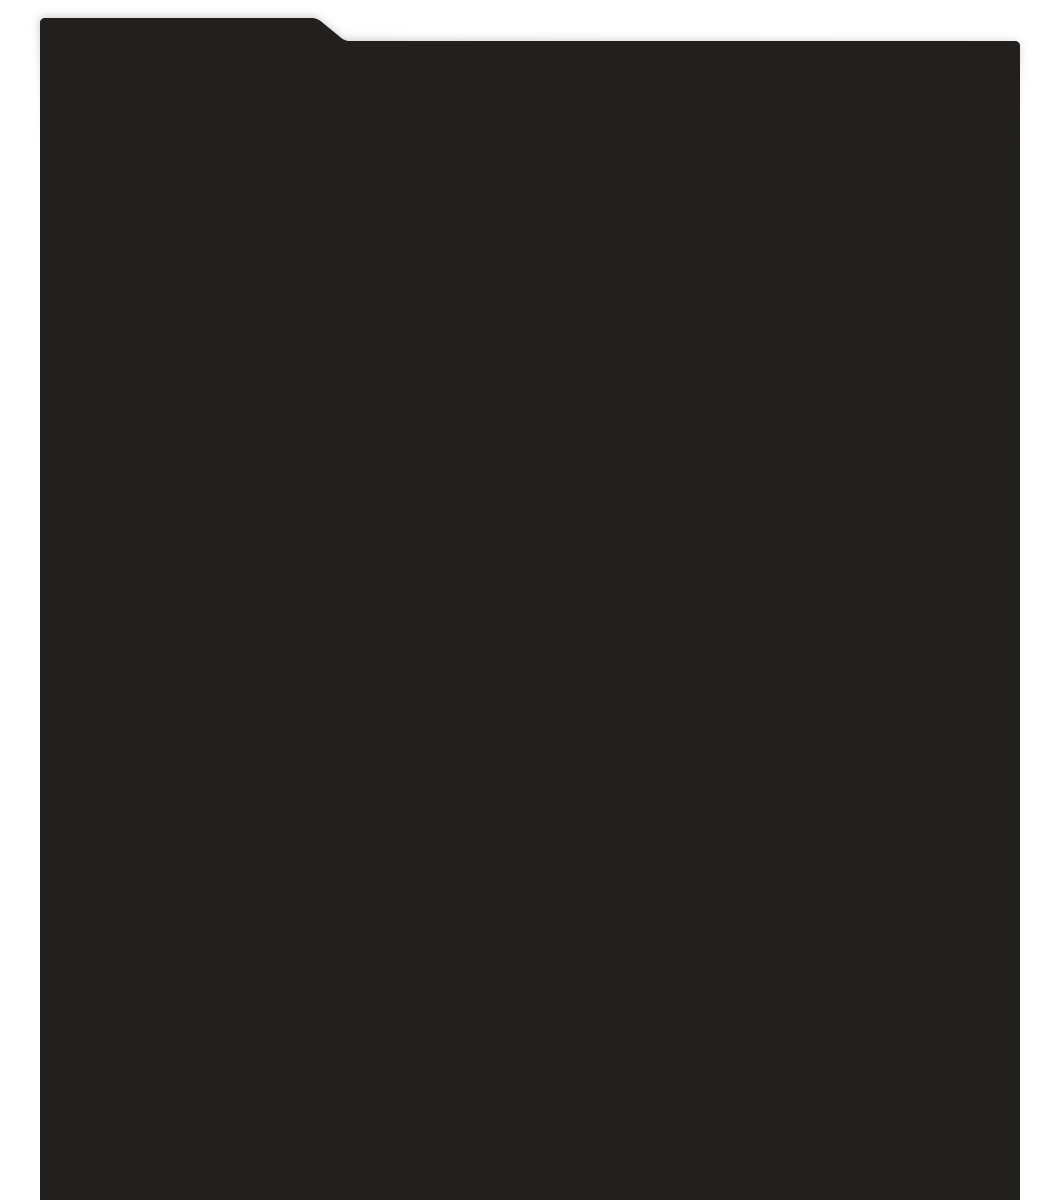
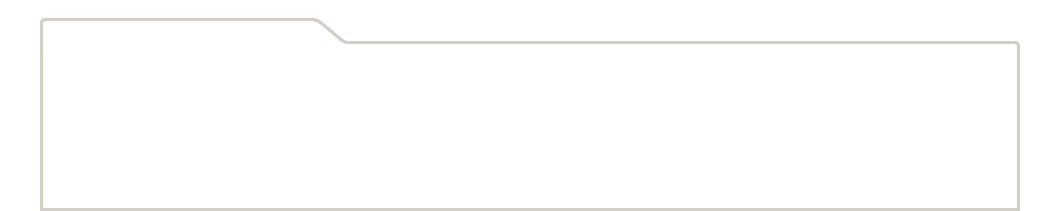
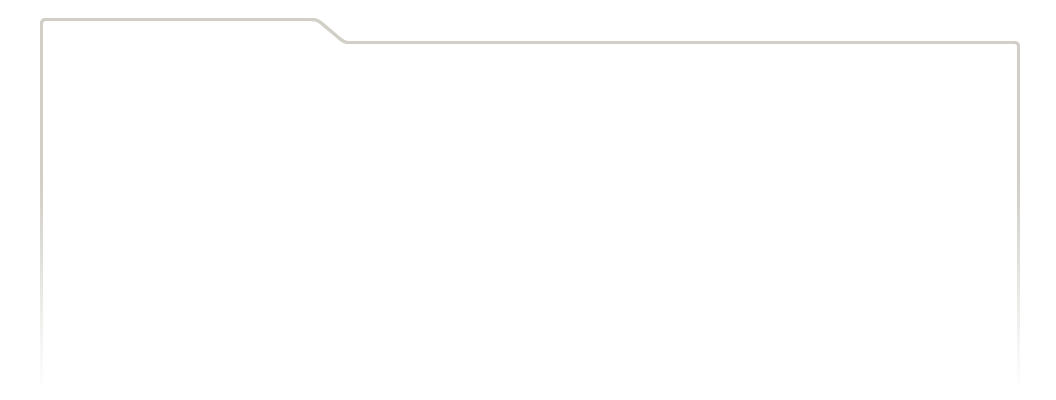
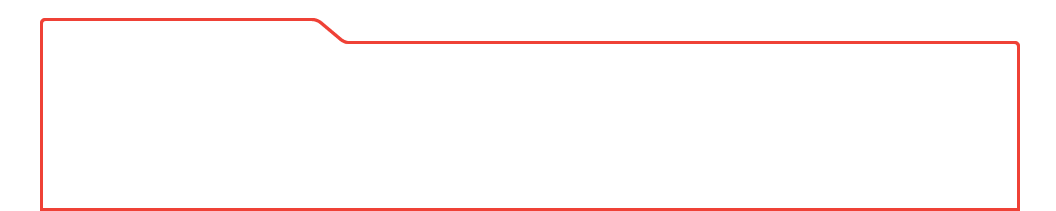
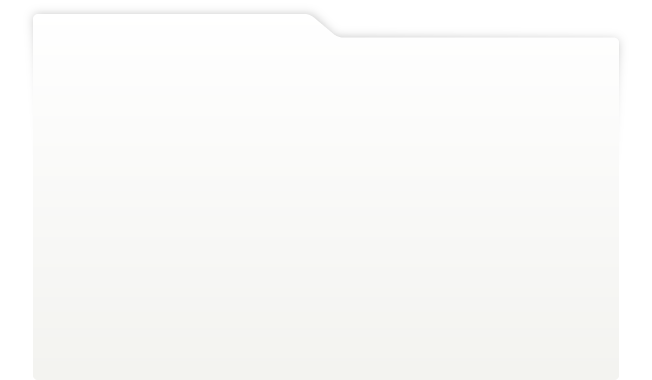
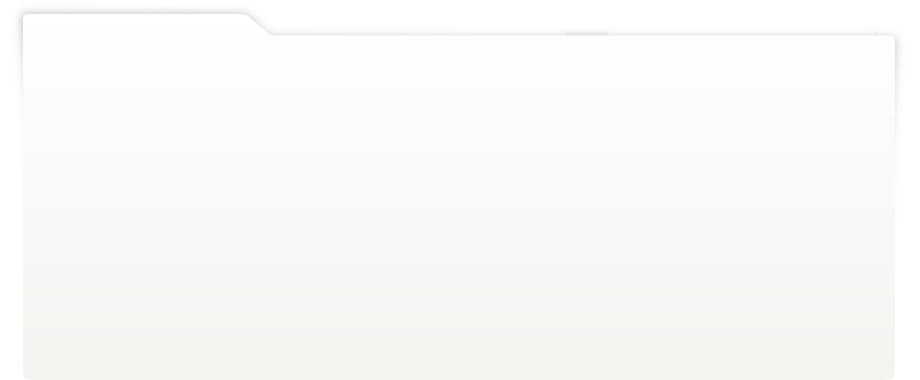
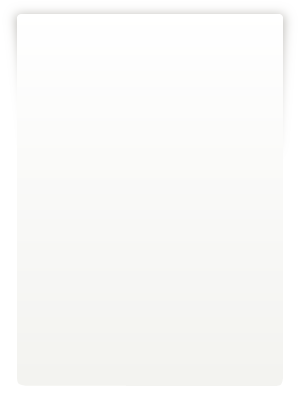
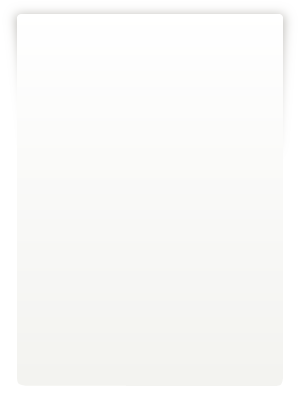
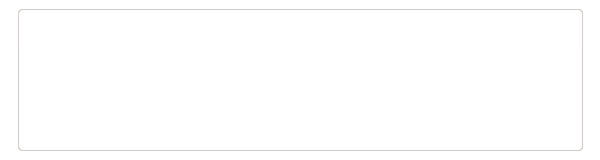
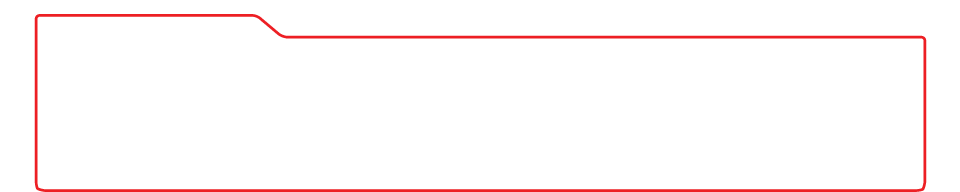
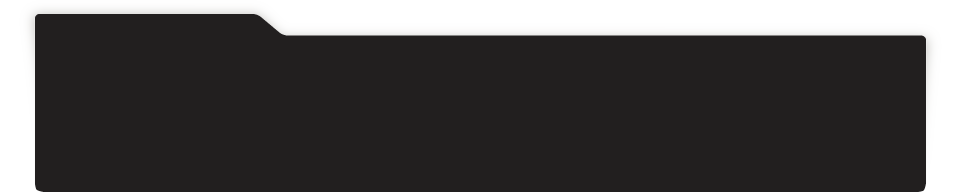
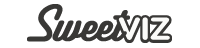
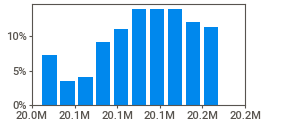
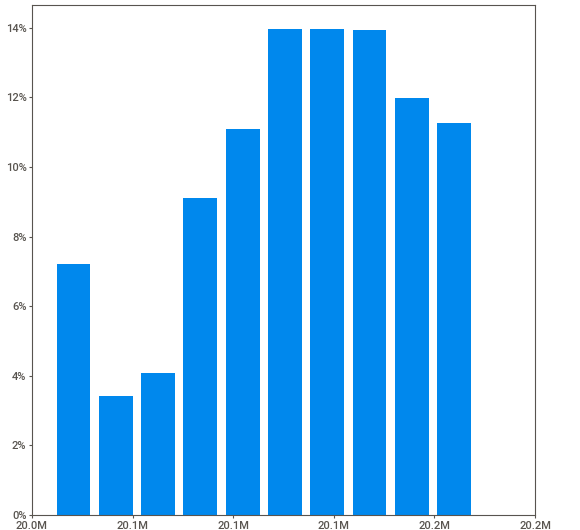
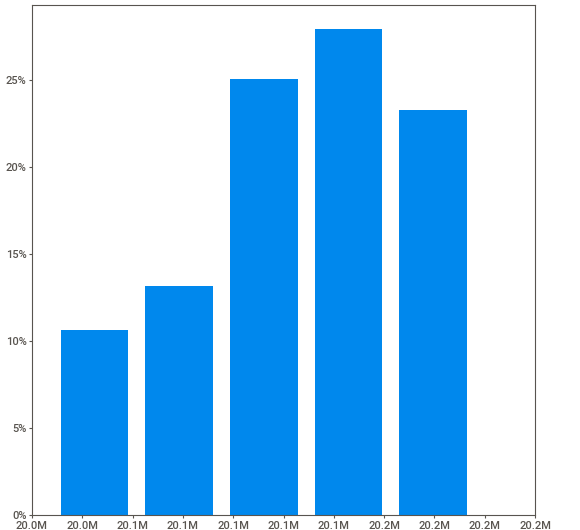
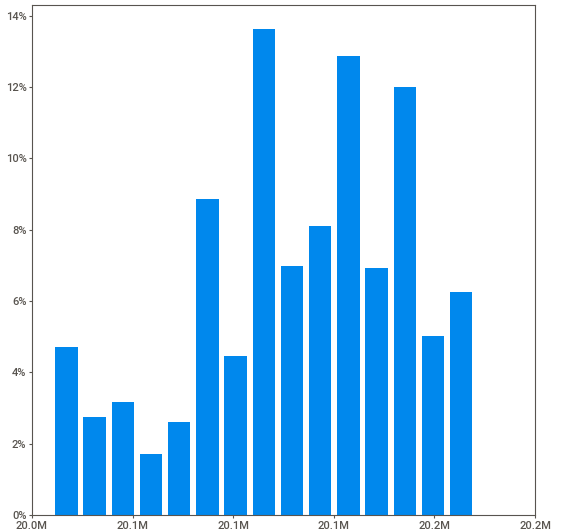
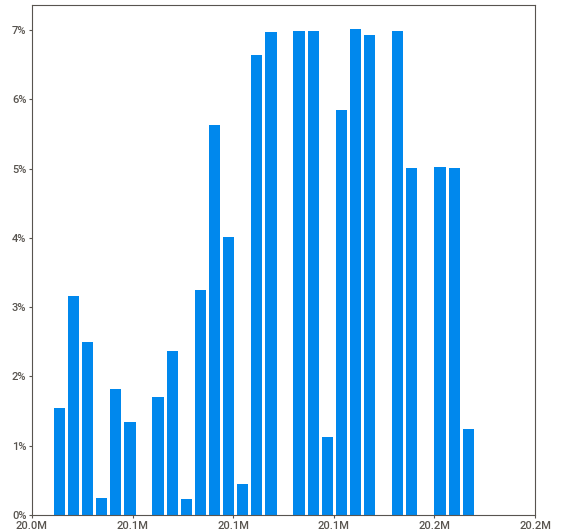
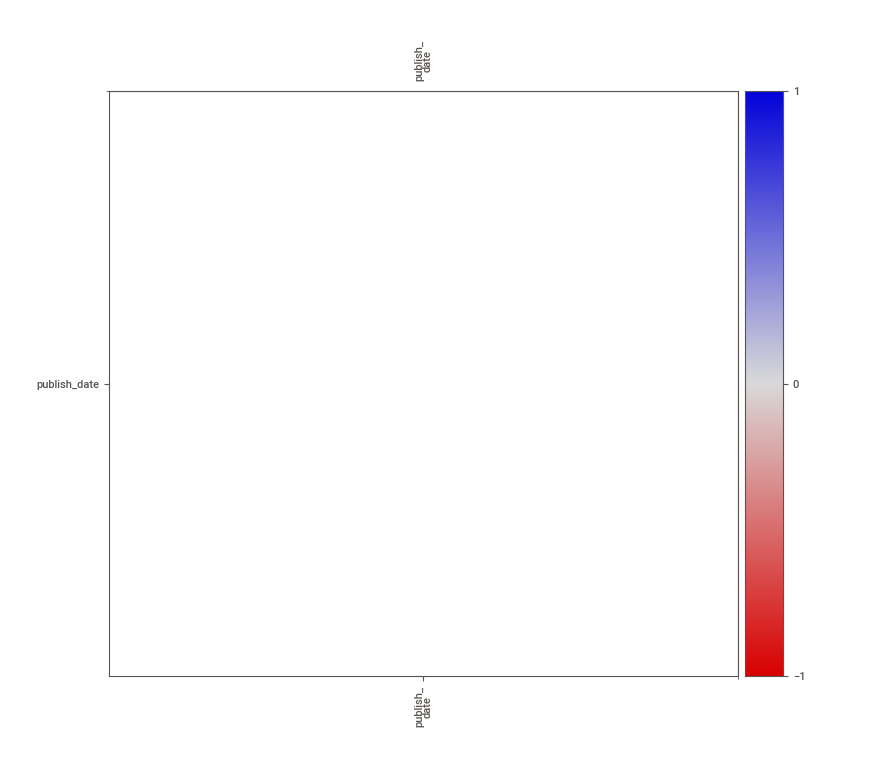
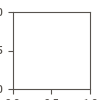

In [20]:
import sweetviz
autoEDA = sweetviz.analyze(news)
autoEDA.show_notebook()

In [21]:
#Renaming the column 'headline_text'
news.rename(columns={'headline_text':'News'}, inplace=True)

In [22]:
#After checking the info of dataframe, the datatype of date not date(int and object)
Date=[]
for date_str in news['publish_date']:
  date_obj = datetime.datetime.strptime(str(date_str), '%Y%m%d').date()
  Date.append(date_obj)
news['Date'] = Date

In [23]:
# Changing type of 'Date' from object to datetime
news['Date']=pd.to_datetime(news['Date'])

In [24]:
#As we can see 'headline_category' and 'category' has no specific relevance and won't effect the end analysis
#Removing these above mentioned columns and publish_date
news.drop(columns=['headline_category','category','publish_date'],inplace=True)

In [25]:
#Let's check if the respective changes have been made
news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3626110 entries, 0 to 3650969
Data columns (total 2 columns):
 #   Column  Dtype         
---  ------  -----         
 0   News    object        
 1   Date    datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 83.0+ MB


In [26]:
#now we have to remove all the special characters
def SpecialChars(text):
    final_text=" "
    for i in text:
        if i.isalnum()  or i==' ':
            final_text= final_text+i
        else:
            final_text=final_text + " "
    return final_text.strip()

In [27]:
news_df=news
news_df['News']=news_df['News'].apply(SpecialChars)

In [28]:
news_df.head()

,News,Date
0,Status quo will not be disturbed at Ayodhya s...,2001-01-02
1,Fissures in Hurriyat over Pak visit,2001-01-02
2,America s unwanted heading for India,2001-01-02
3,For bigwigs it is destination Goa,2001-01-02
4,Extra buses to clear tourist traffic,2001-01-02


In [29]:
# Combining different types of News on a single date
news_df['News']=news_df.groupby(['Date']).transform(lambda x: " ".join(x))

In [30]:
news_df

,News,Date
0,Status quo will not be disturbed at Ayodhya s...,2001-01-02
1,Status quo will not be disturbed at Ayodhya s...,2001-01-02
2,Status quo will not be disturbed at Ayodhya s...,2001-01-02
3,Status quo will not be disturbed at Ayodhya s...,2001-01-02
4,Status quo will not be disturbed at Ayodhya s...,2001-01-02
...,...,...
3650965,Shashank goes back to coastal Karnataka and Mo...,2022-03-31
3650966,Shashank goes back to coastal Karnataka and Mo...,2022-03-31
3650967,Shashank goes back to coastal Karnataka and Mo...,2022-03-31
3650968,Shashank goes back to coastal Karnataka and Mo...,2022-03-31


In [31]:
news_df.drop_duplicates(inplace=True)
news_df.reset_index(inplace=True,drop=True)

In [32]:
#Finding the Subjectivity and Polarity of a particular day by assessing the news
def Subjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def Polarity(text):
  return TextBlob(text).sentiment.polarity

In [33]:
#Adding them to the news_df dataframe
news_df['Subjectivity']=news_df['News'].apply(Subjectivity)
news_df['Polarity']=news_df['News'].apply(Polarity)

<Axes: >

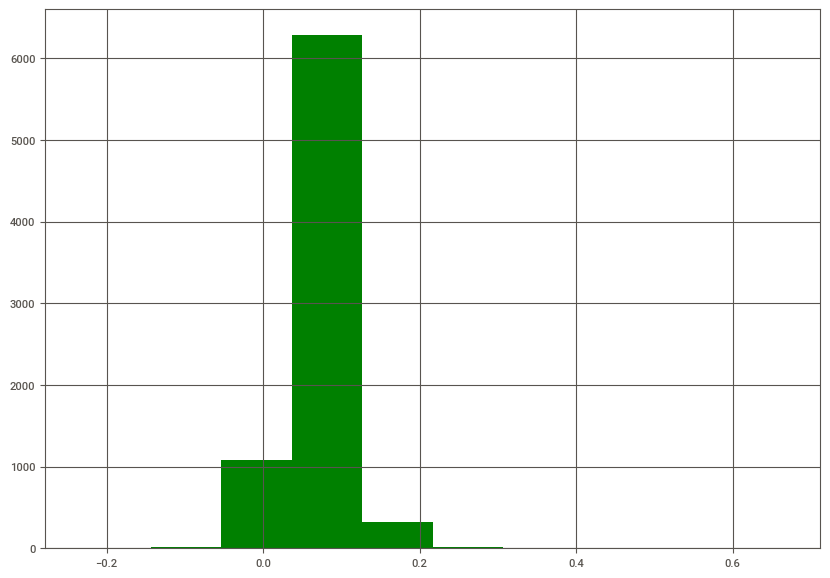

In [34]:
plt.figure(figsize=(10,7))
news_df['Polarity'].hist(color='green')

<Axes: >

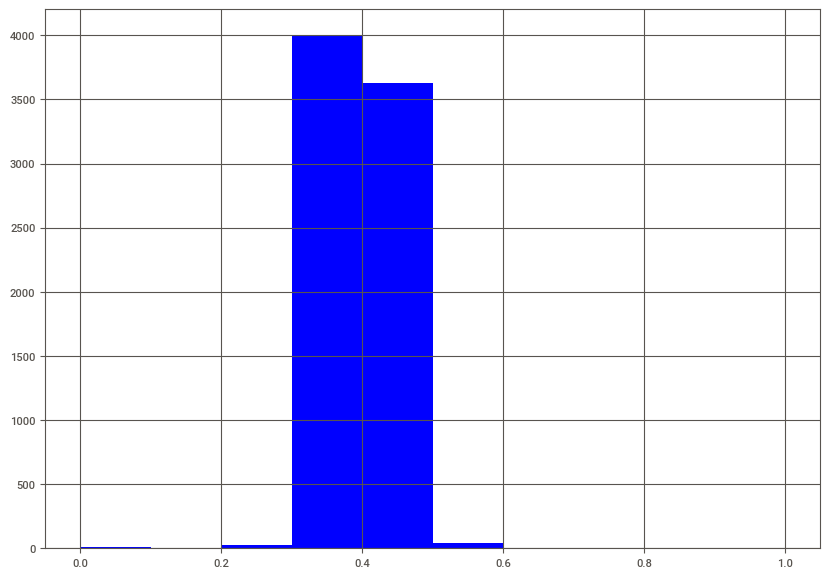

In [35]:
plt.figure(figsize=(10,7))
news_df['Subjectivity'].hist(color='blue')

In [36]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [37]:
#Adding all the sentiment scores to our dataframe news_df
sia = SentimentIntensityAnalyzer()

news_df['Compound'] = [sia.polarity_scores(v)['compound'] for v in news_df['News']]
news_df['Negative'] = [sia.polarity_scores(v)['neg'] for v in news_df['News']]
news_df['Neutral'] = [sia.polarity_scores(v)['neu'] for v in news_df['News']]
news_df['Positive'] = [sia.polarity_scores(v)['pos'] for v in news_df['News']]
news_df

,News,Date,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,Status quo will not be disturbed at Ayodhya s...,2001-01-02,0.298684,0.180702,-0.9839,0.141,0.792,0.068
1,Powerless north India gropes in the dark Think...,2001-01-03,0.392857,0.089286,-0.8910,0.154,0.739,0.107
2,The string that pulled Stephen Hawking to Indi...,2001-01-04,0.478086,0.089802,0.9178,0.102,0.784,0.114
3,Light combat craft takes India into club class...,2001-01-05,0.470967,0.260138,0.9753,0.127,0.690,0.183
4,Light combat craft takes India into club class...,2001-01-06,0.464935,0.219481,-0.8625,0.227,0.653,0.119
...,...,...,...,...,...,...,...,...
7712,Playing a dead man in Body God meant sitting i...,2022-03-27,0.362505,0.034634,-0.9999,0.156,0.764,0.081
7713,As fashion becomes democratic demand for styl...,2022-03-28,0.381673,0.058309,-0.9999,0.159,0.740,0.102
7714,Bobby Deol Like my dad I hope to be working ...,2022-03-29,0.400425,0.091291,-0.9999,0.158,0.759,0.084
7715,I will not give in to trends Dossmode The tim...,2022-03-30,0.340023,0.039476,-0.9999,0.153,0.773,0.073


####Numerical Analysis

                                             |          | [  0%]   00:00 -> (? left)


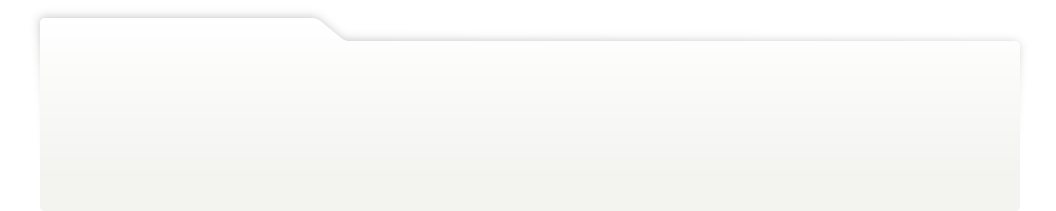
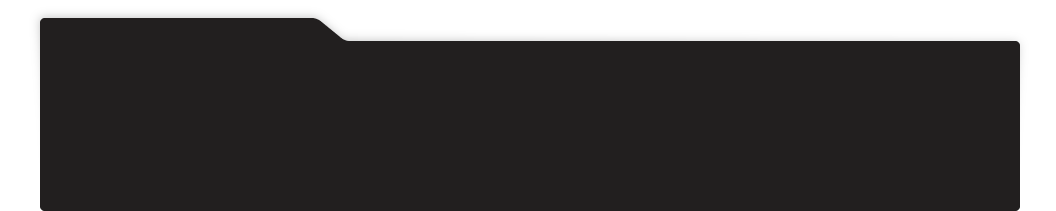
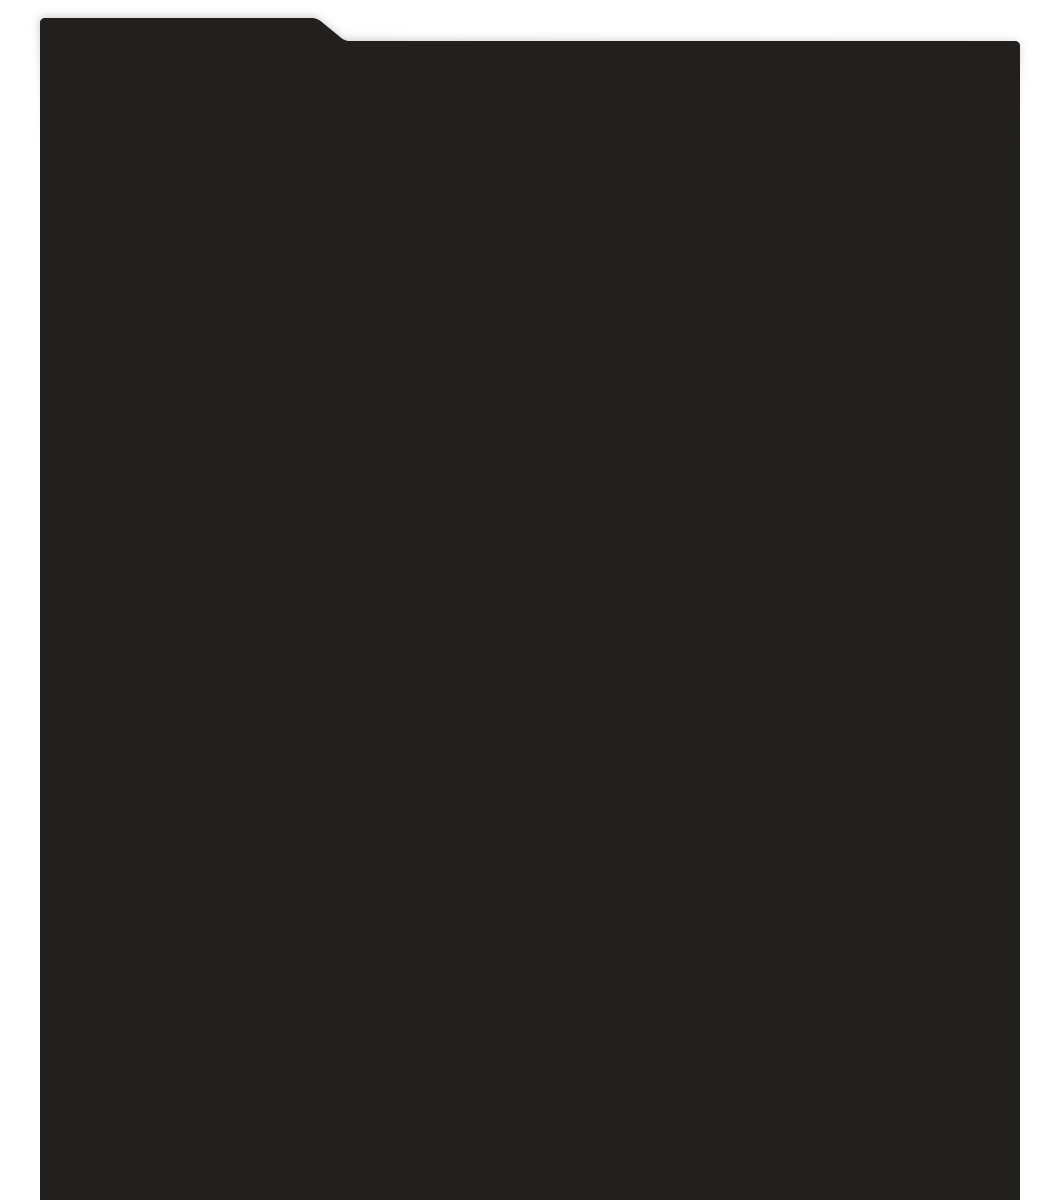
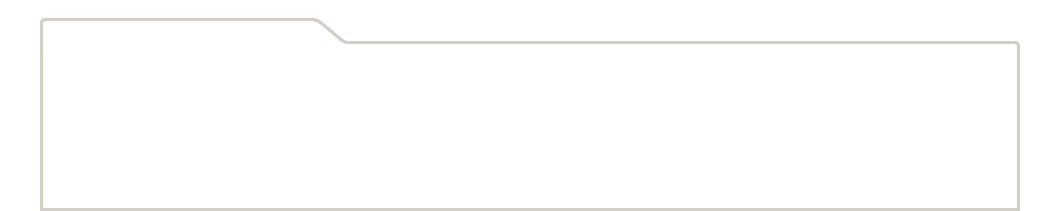
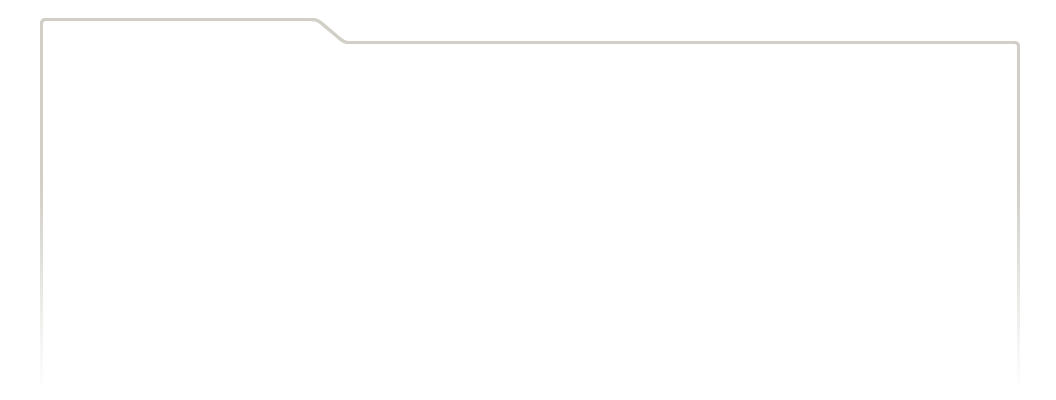
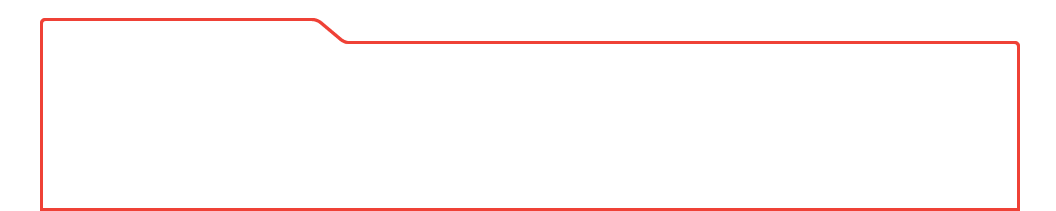
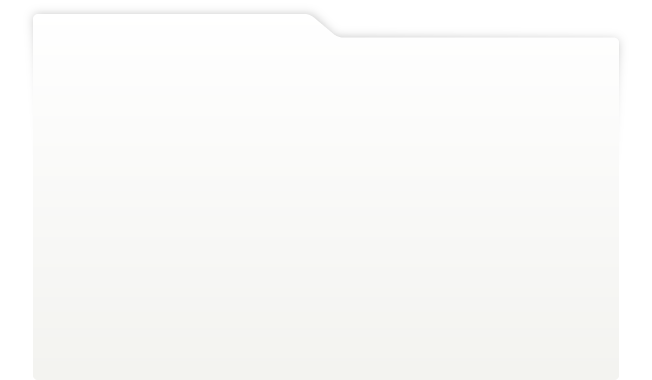
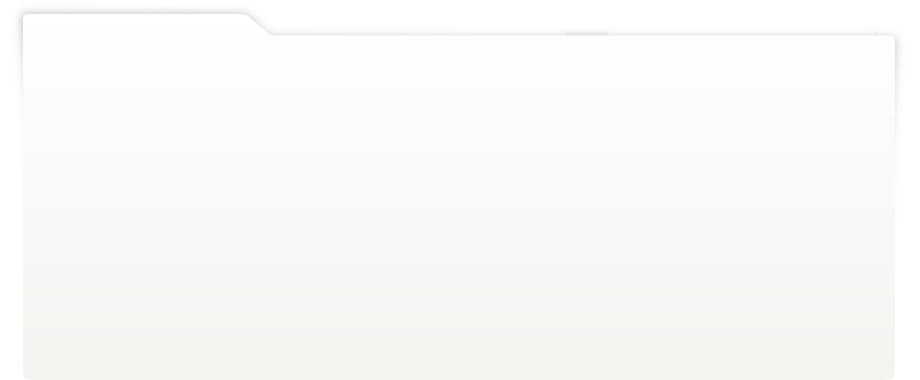
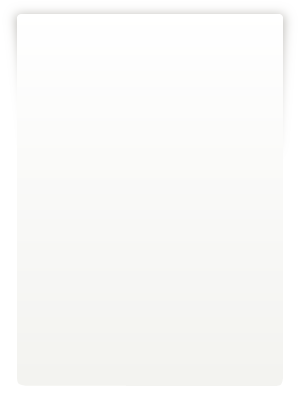
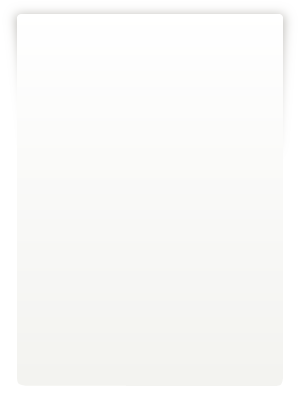
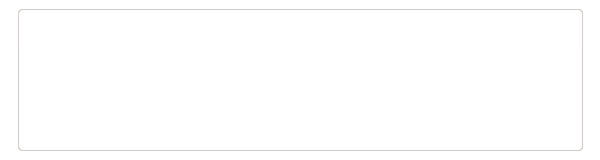
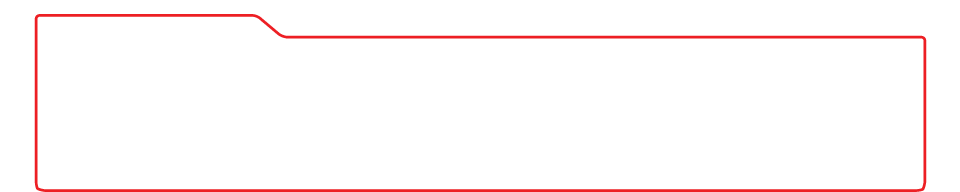
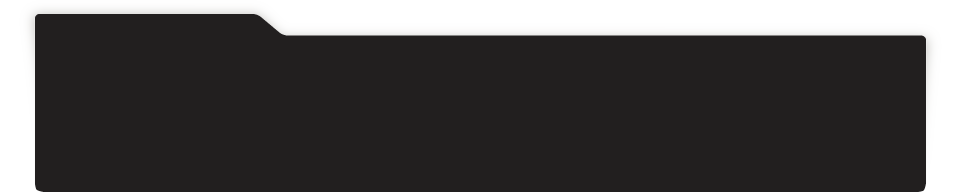
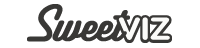
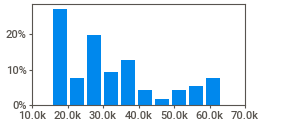
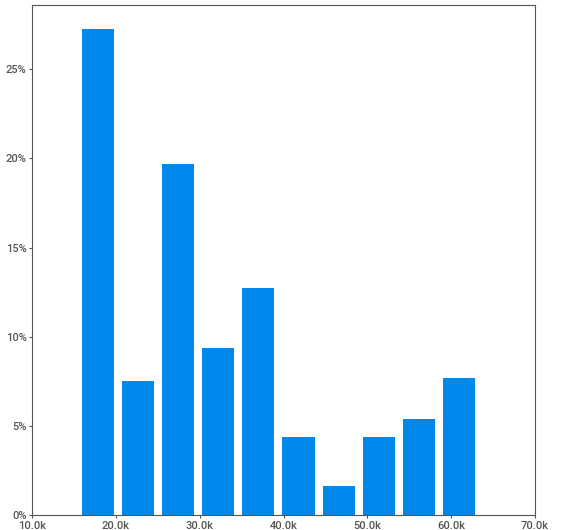
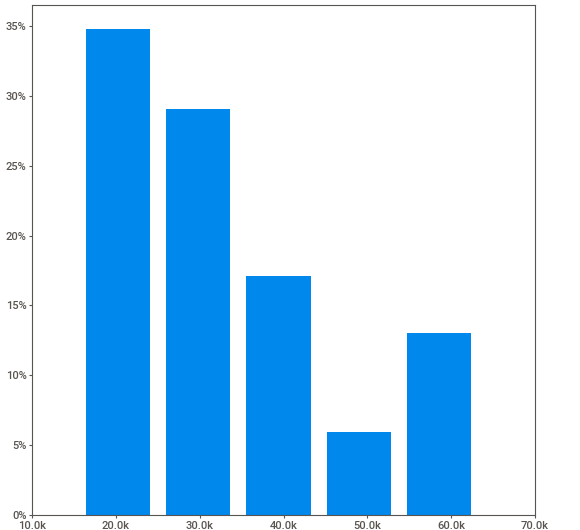
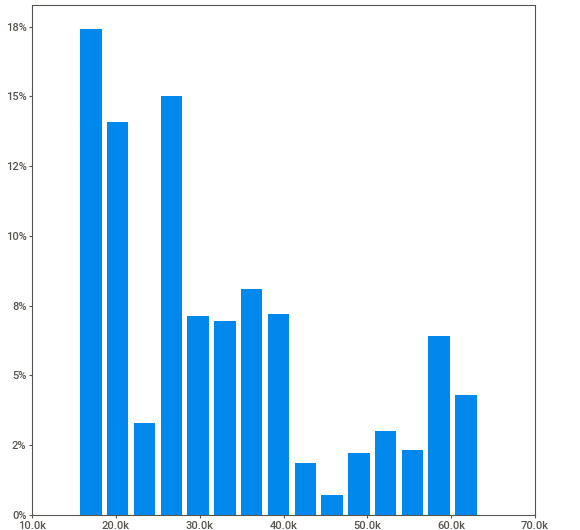
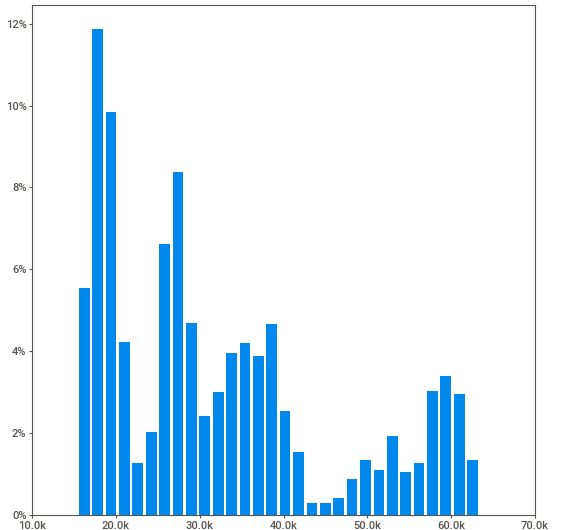
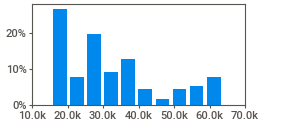
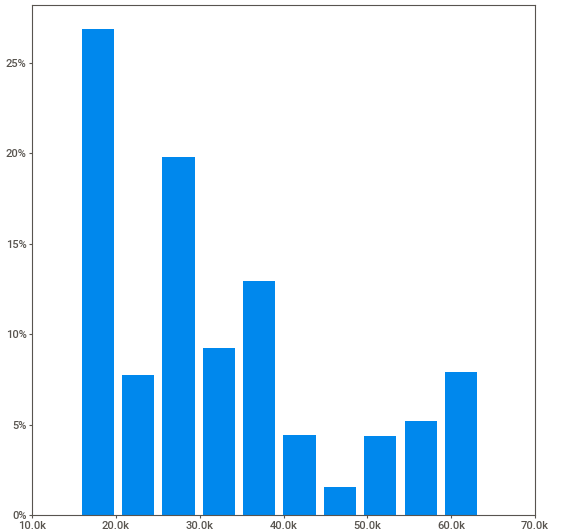
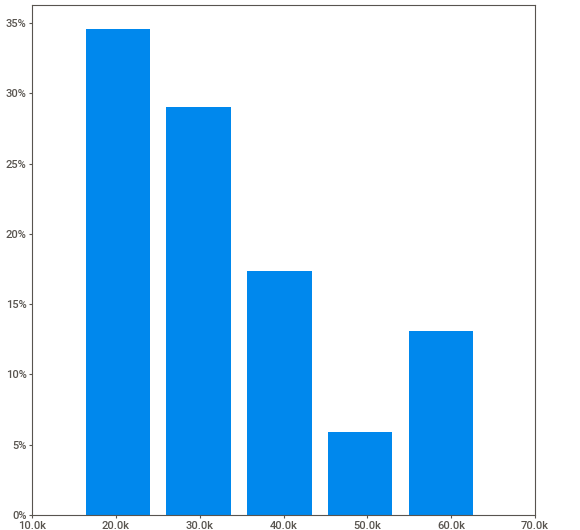
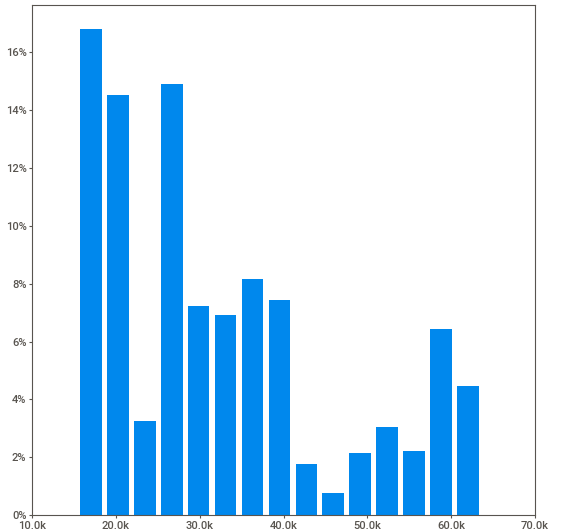
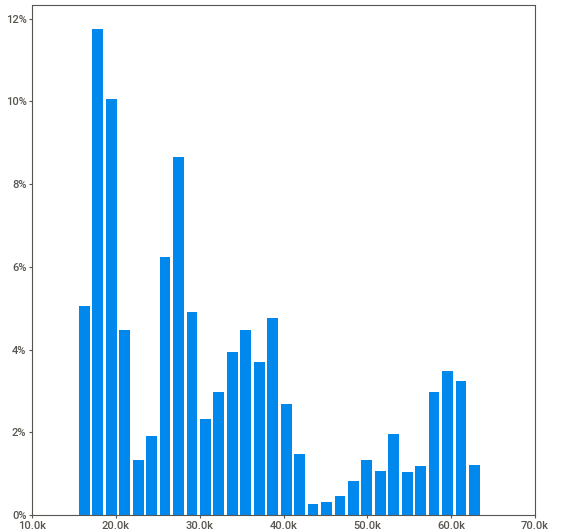
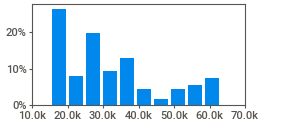
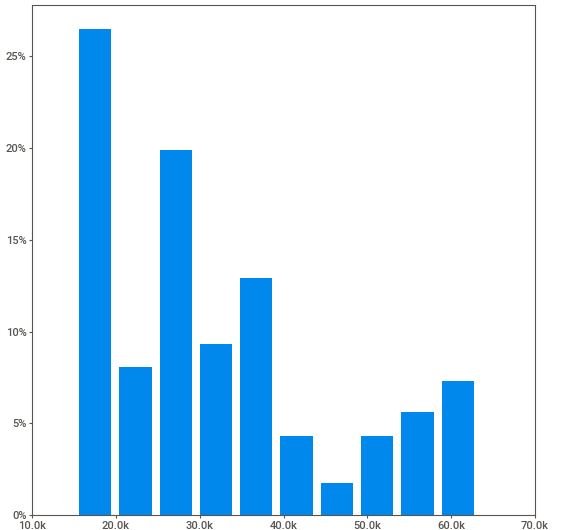
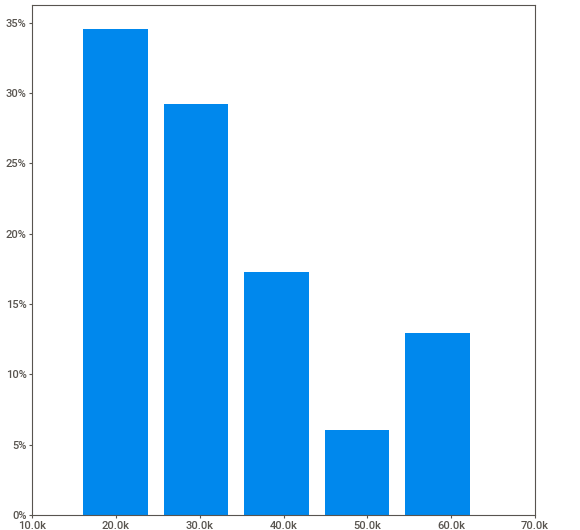
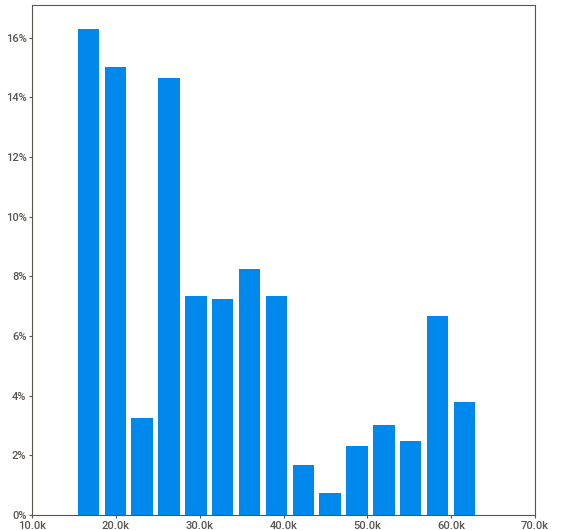
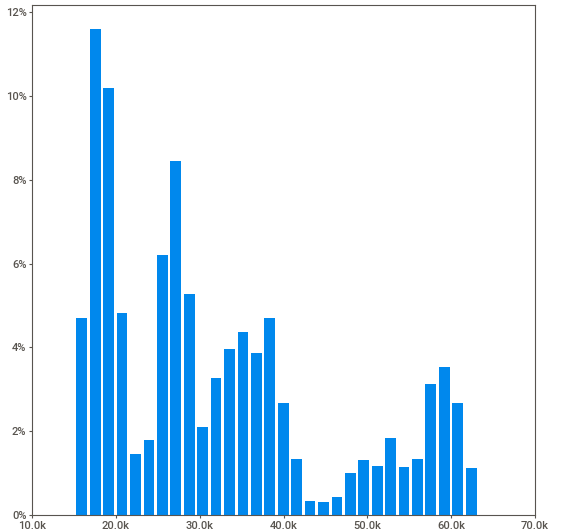
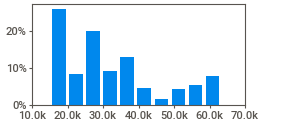
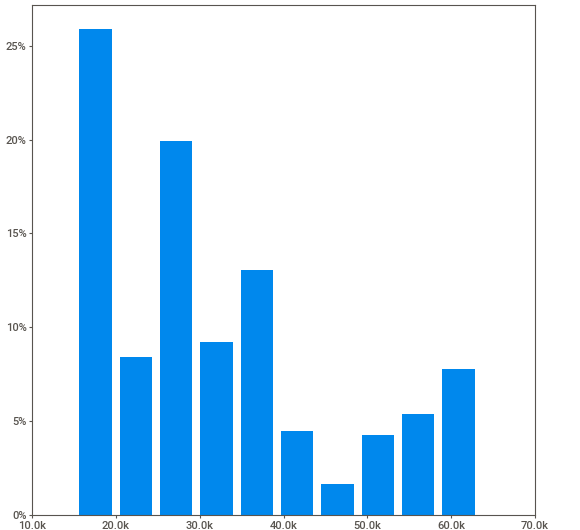
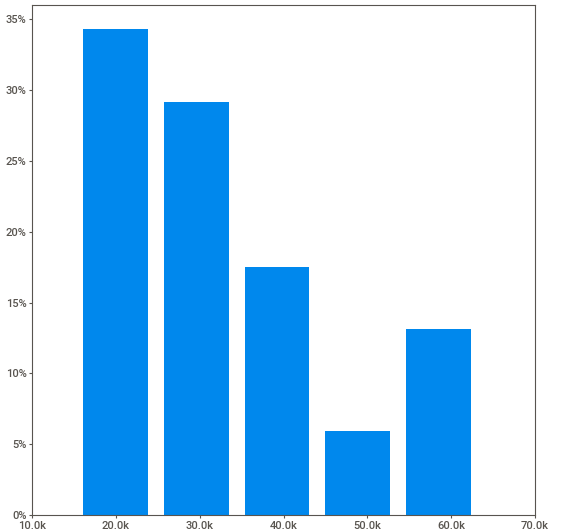
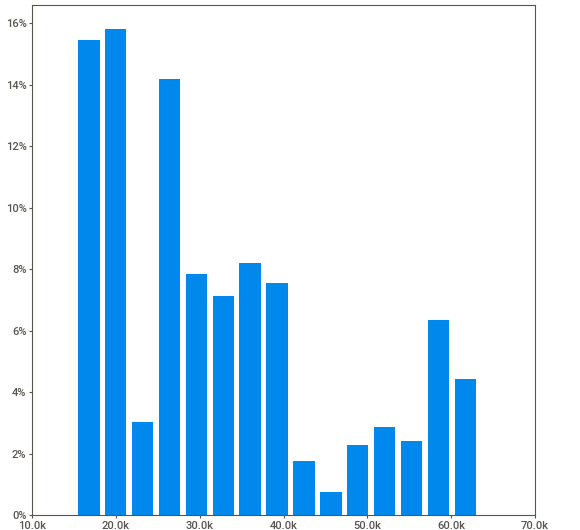
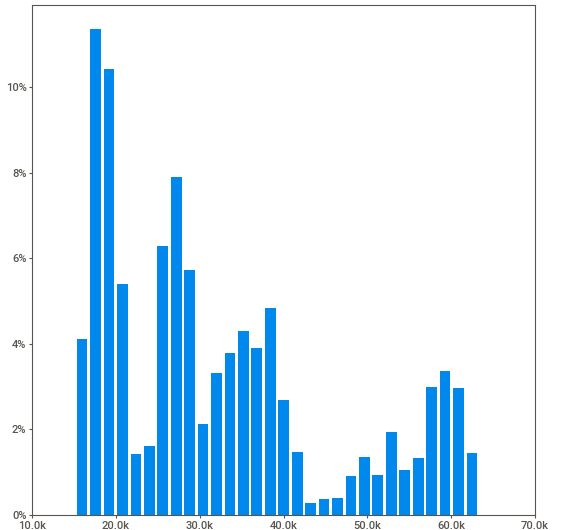
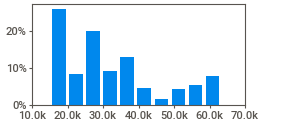
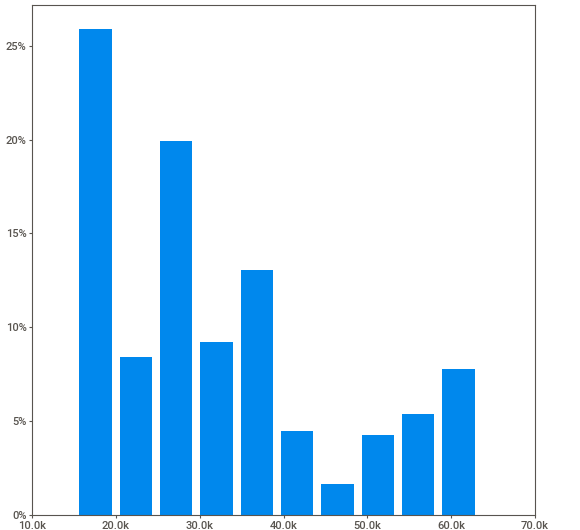
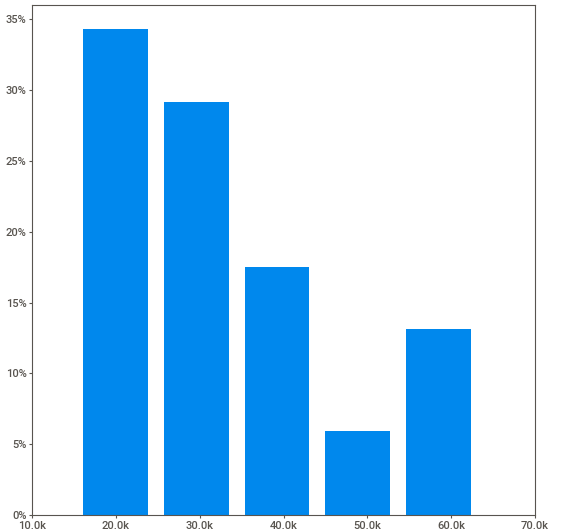
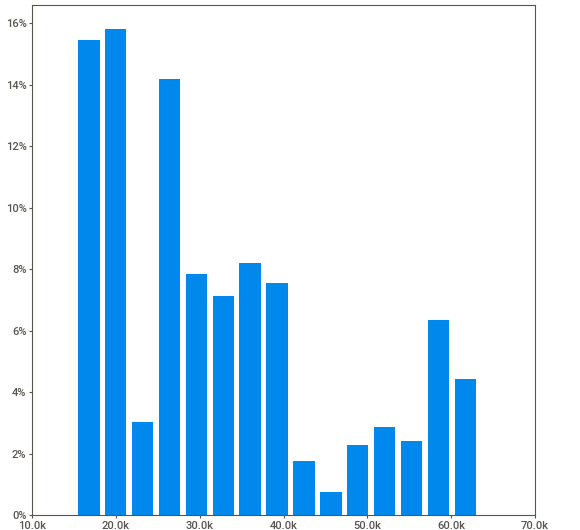
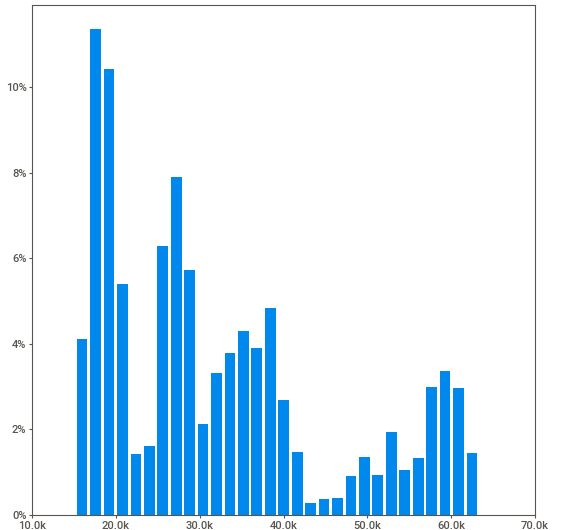
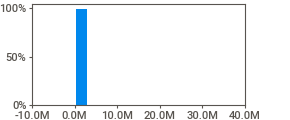
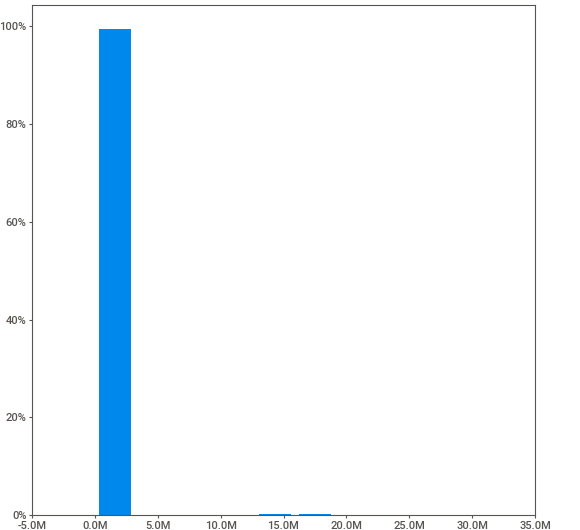
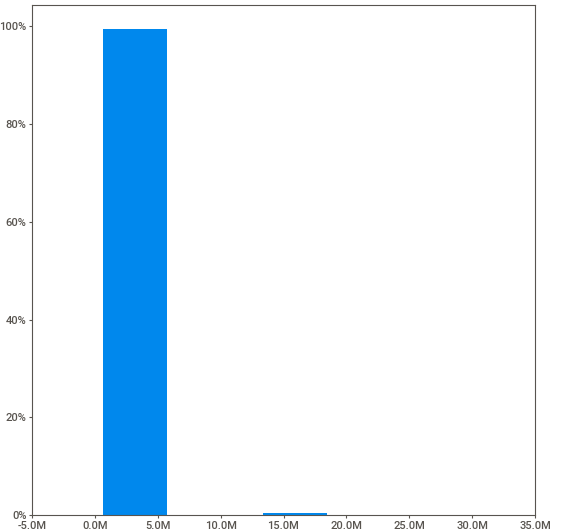
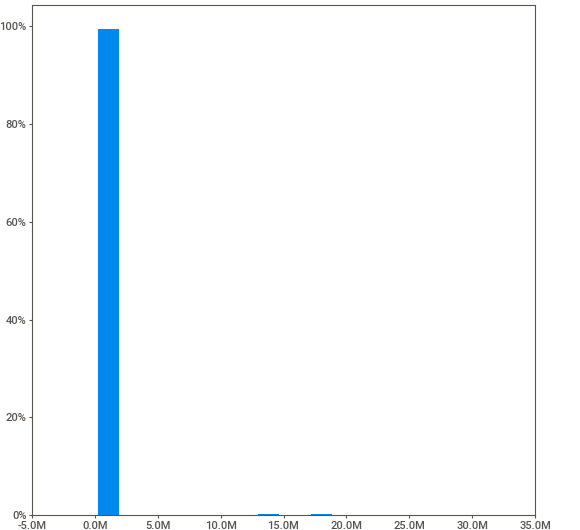
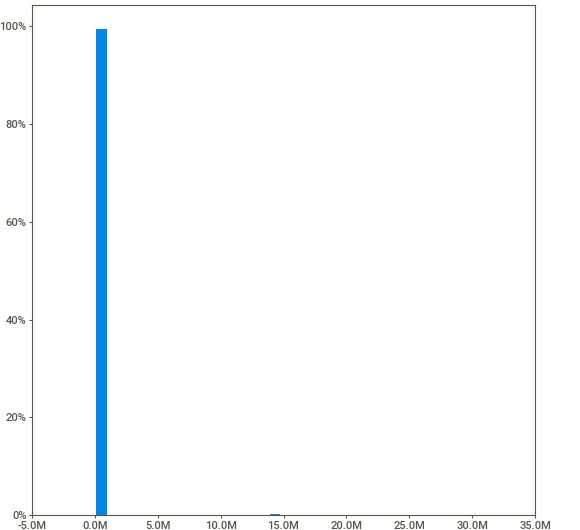
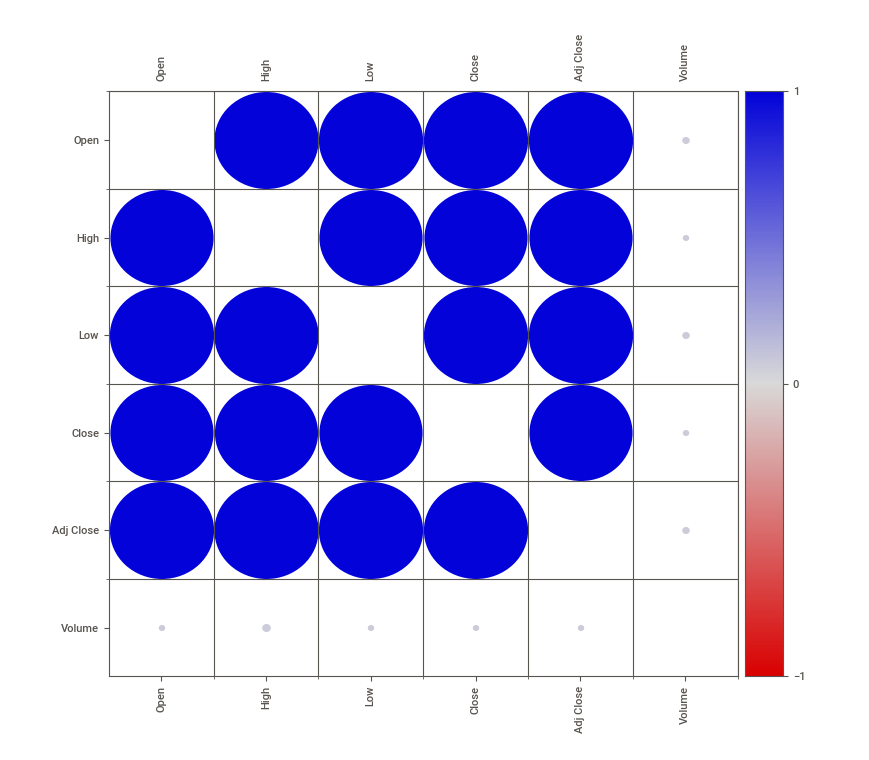
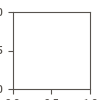

In [38]:
autoEDA = sweetviz.analyze(stock)
autoEDA.show_notebook()

In [39]:
# 'Adj Close' and 'Close' have the same entries
stock=stock.drop(['Adj Close'],axis=1)

In [40]:
stock.head()

,Date,Open,High,Low,Close,Volume
0,2010-01-04,17473.449219,17582.839844,17378.380859,17558.730469,28200
1,2010-01-05,17555.769531,17729.779297,17555.769531,17686.240234,27000
2,2010-01-06,17719.470703,17790.330078,17636.710938,17701.130859,21400
3,2010-01-07,17701.970703,17733.339844,17566.539062,17615.720703,18000
4,2010-01-08,17603.869141,17658.119141,17508.960938,17540.289062,17200


Text(0.5, 1.0, 'Closing Price Graph')

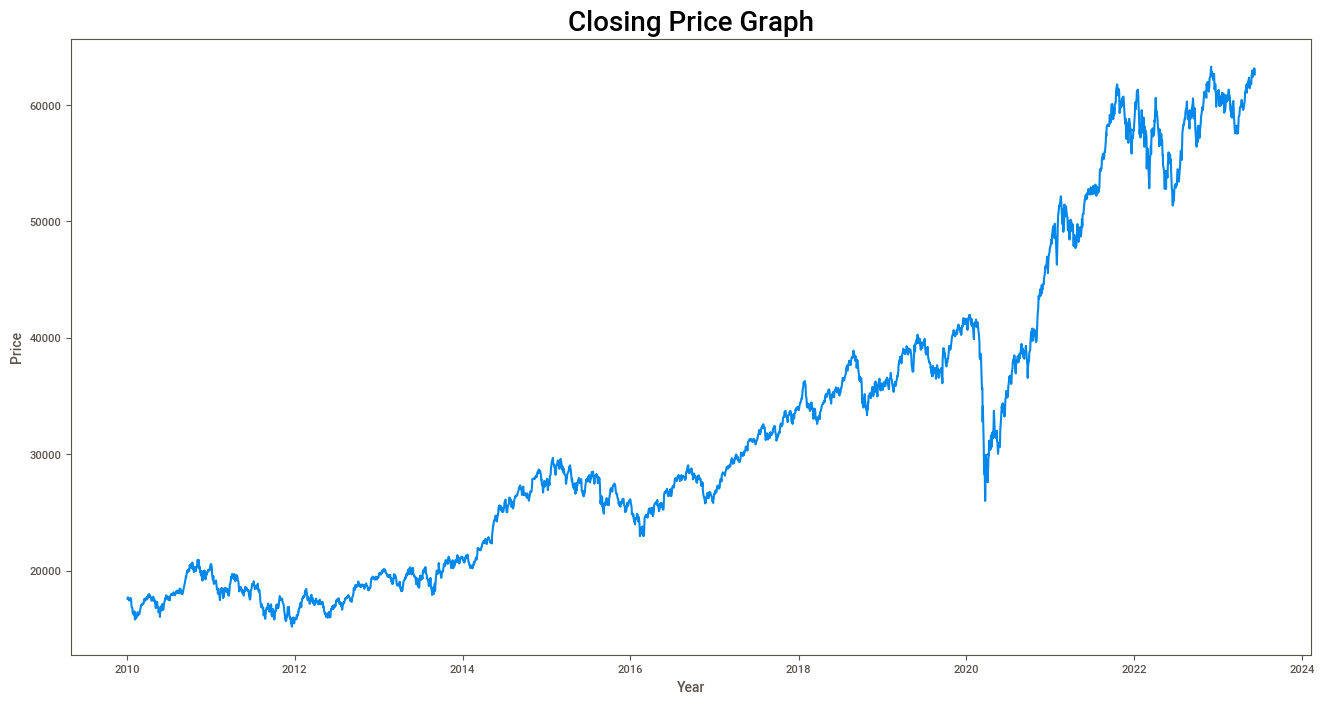

In [41]:
# Closing Graph
plt.figure(figsize=(16,8))
plt.plot(stock['Date'],stock['Close'])
plt.ylabel('Price')
plt.xlabel('Year')
plt.title('Closing Price Graph',fontsize=20)

Text(0.5, 0, 'Year')

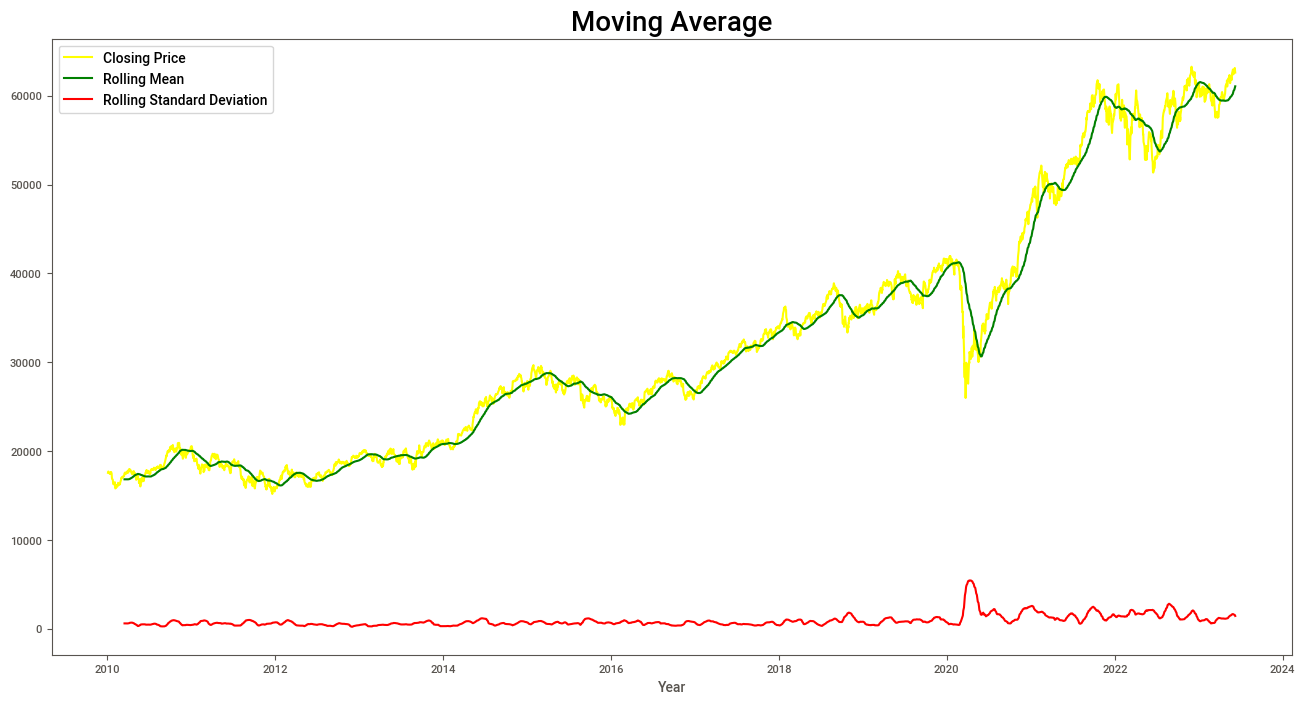

In [42]:
close=stock['Close']

# Finding the rolling mean and rolling standard deviation after every 50 entries
mean=close.rolling(window=50).mean()
std=close.rolling(window=50).std()

# Plotting the Rolling Mean and Rolling Standard Deviation and Closing Price Graphs wrt Date
plt.figure(figsize=(16,8))
plt.plot(stock['Date'], stock['Close'], color='yellow', label='Closing Price')
plt.plot(stock['Date'], mean, color='green', label='Rolling Mean')
plt.plot(stock['Date'], std, color='red', label='Rolling Standard Deviation')

plt.legend()
plt.title("Moving Average",fontsize=20)
plt.xlabel("Year")

Text(0.5, 1.0, 'Returns')

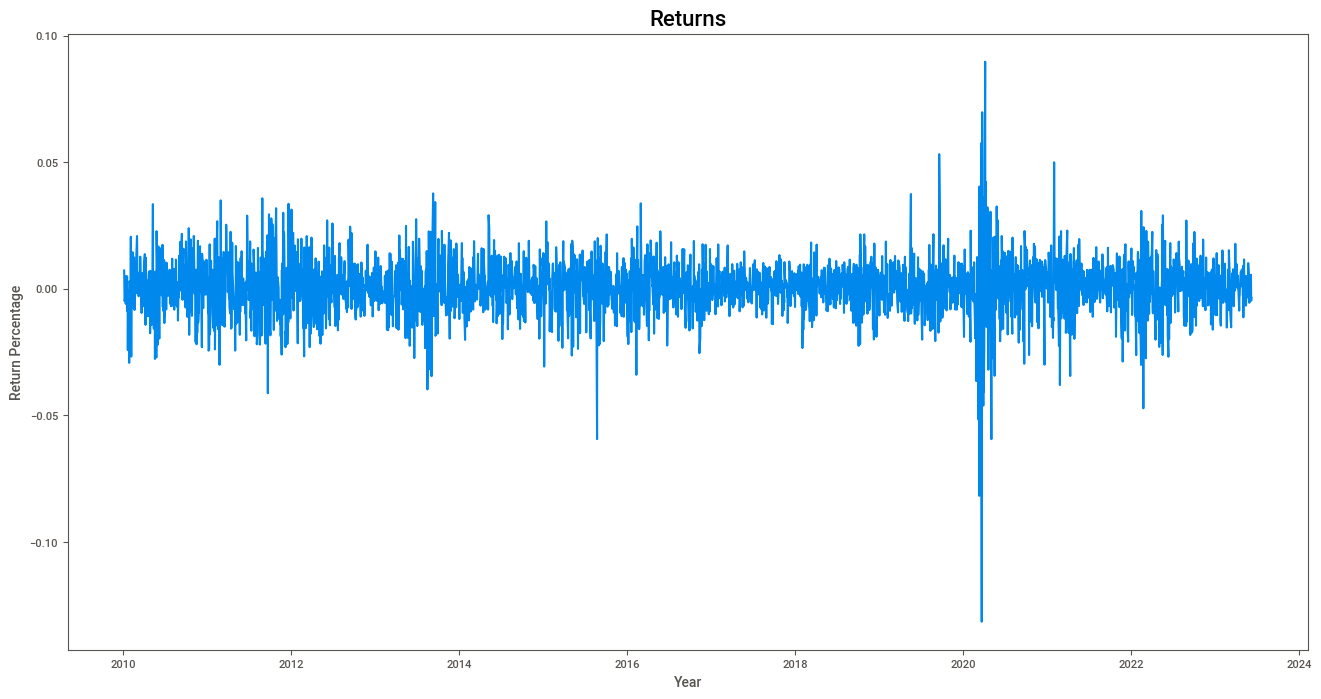

In [43]:
# This calculation represents the percentage change between consecutive values in the close variable
returns = close/close.shift(1)-1
plt.figure(figsize = (16,8))
plt.plot(stock['Date'],returns)
plt.xlabel('Year')
plt.ylabel('Return Percentage')
plt.title('Returns',fontsize=16)

In [44]:
#Stationary Test
def StationaryTest(timeseries):
  rol_mean=timeseries.rolling(20).mean()
  rol_std=timeseries.rolling(20).std()
  plt.figure(figsize=(10,8))
  timeseries.plot(color='red',label='Original')
  rol_mean.plot(color='yellow',label='Rolling Mean')
  rol_std.plot(color='green',label='Rolling Standard Deviation')
  plt.legend()
  plt.title('Rolling Mean and Rolling Standard Deviation',  fontsize = 20)
  print('Results of Dickey Fuller Test')
  result = adfuller(timeseries, autolag = 'AIC')
  labels = ['ADF Test Statistic','p-value','Lags Used','Number of Observations Used']
  for value,label in zip(result, labels):
    print(label+' : '+str(value) )
  if result[1] <= 0.05:
    print("Strong evidence against the null hypothesis, reject the null hypothesis. \n Timeseries Dataset is stationary")
  else:
    print("Weak evidence against null hypothesis.\n Timeseries Dataset is non-stationary ")

In [45]:
#splitting of data
test=stock[2120:]
train=stock[:2120]       

Results of Dickey Fuller Test
ADF Test Statistic : 0.34765078589284126
p-value : 0.9794281078343905
Lags Used : 1
Number of Observations Used : 2118
Weak evidence against null hypothesis.
 Timeseries Dataset is non-stationary 


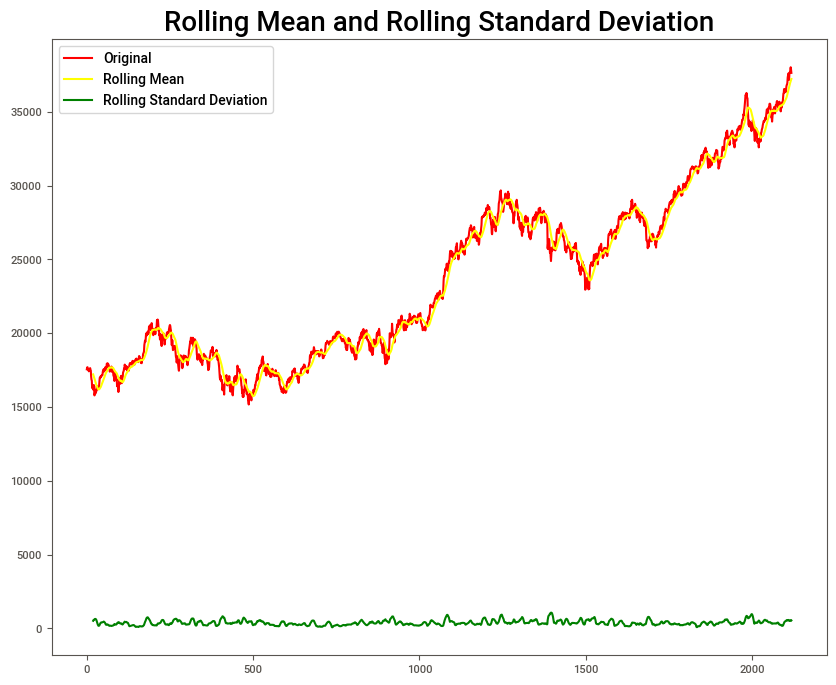

In [46]:
#Stationary Test on Train df closing price
StationaryTest(train['Close'])

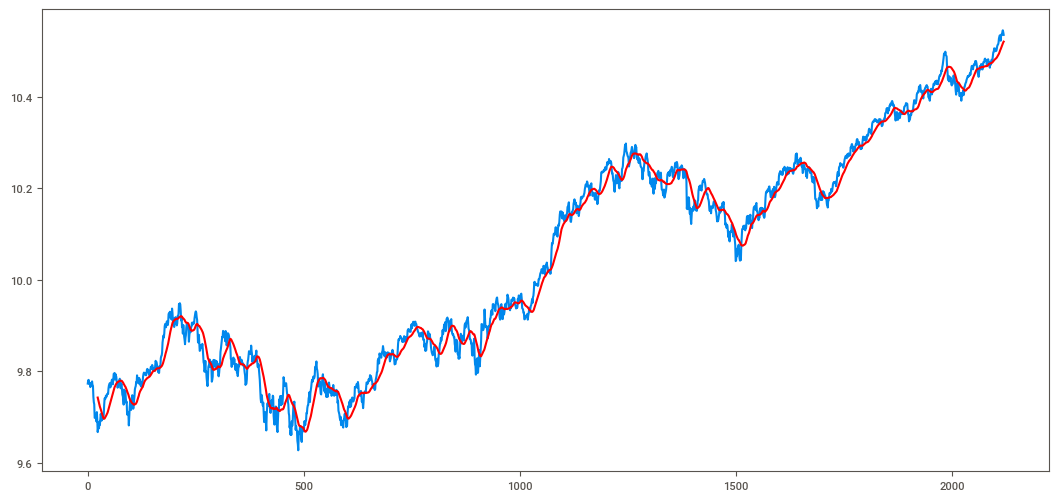

In [47]:
train_log = np.log(train['Close']) 
test_log = np.log(test['Close'])
train_log_rmean = train_log.rolling(24).mean() 
plt.figure(figsize = (13,6))
plt.plot(train_log) 
plt.plot(train_log_rmean, color = 'red') 

Results of Dickey Fuller Test
ADF Test Statistic : -0.23543191914541256
p-value : 0.9341643266392672
Lags Used : 1
Number of Observations Used : 2118
Weak evidence against null hypothesis.
 Timeseries Dataset is non-stationary 


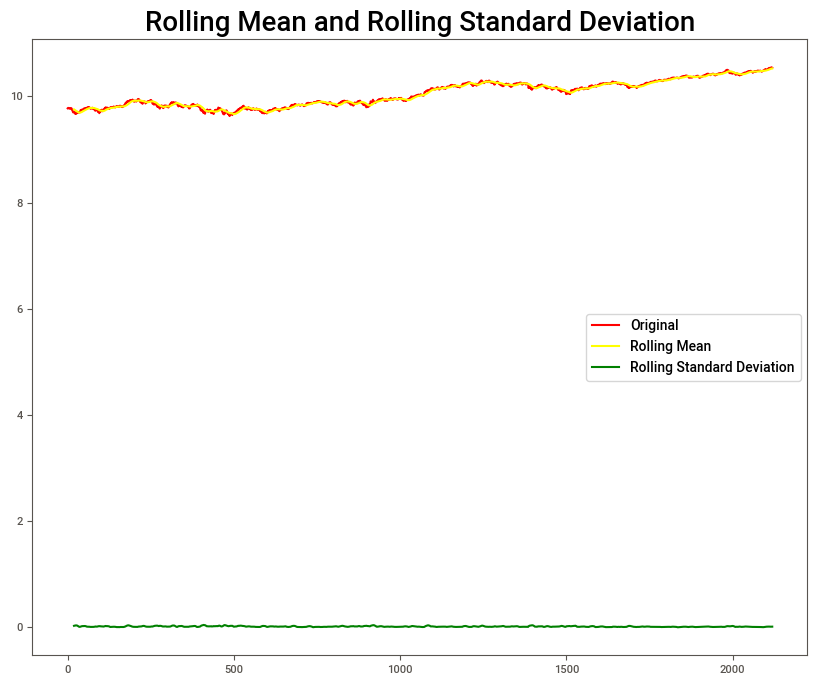

In [48]:
train_log.dropna(inplace = True)
test_log.dropna(inplace = True)
StationaryTest(train_log)

Results of Dickey Fuller Test
ADF Test Statistic : -9.899865632156887
p-value : 3.3802619909664886e-17
Lags Used : 12
Number of Observations Used : 2084
Strong evidence against the null hypothesis, reject the null hypothesis. 
 Timeseries Dataset is stationary


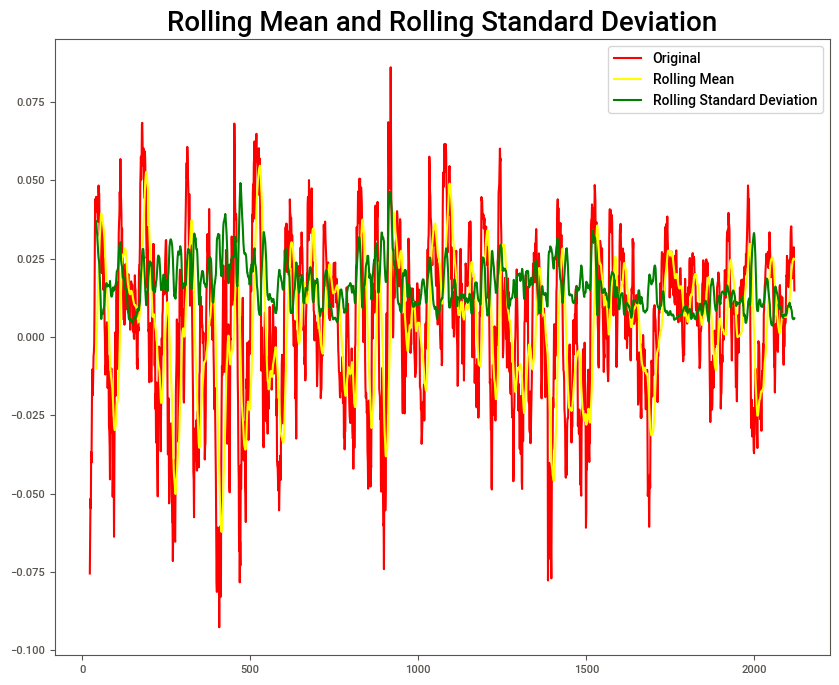

In [49]:
train_log_diff = train_log-train_log_rmean
train_log_diff.dropna(inplace = True)
StationaryTest(train_log_diff)

###Training the ARIMA Model

In [50]:
# Creating ARIMA model
model=auto_arima(train_log,trace=True,error_action='ignore',suppress_warnings=True)
model.summary()

# finding predictions from the above obtained model
predictions=model.predict(n_periods= len(test))
predictions=pd.DataFrame(predictions, index=test_log.index, columns=['Prediction'])
predictions

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-13647.650, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-13644.001, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-13651.592, Time=0.47 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-13651.741, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13643.064, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-13649.764, Time=0.54 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-13649.776, Time=0.58 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-13648.076, Time=0.59 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-13651.157, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 4.161 seconds


,Prediction
2120,10.535902
2121,10.536258
2122,10.536613
2123,10.536969
2124,10.537325
...,...
3299,10.955467
3300,10.955822
3301,10.956178
3302,10.956534


In [51]:
test_log

2120    10.541439
2121    10.536448
2122    10.543969
2123    10.552650
2124    10.552833
          ...    
3299    11.047511
3300    11.047597
3301    11.053157
3302    11.048485
3303    11.044930
Name: Close, Length: 1184, dtype: float64

Text(0, 0.5, 'ACTUAL STOCK PRICE')

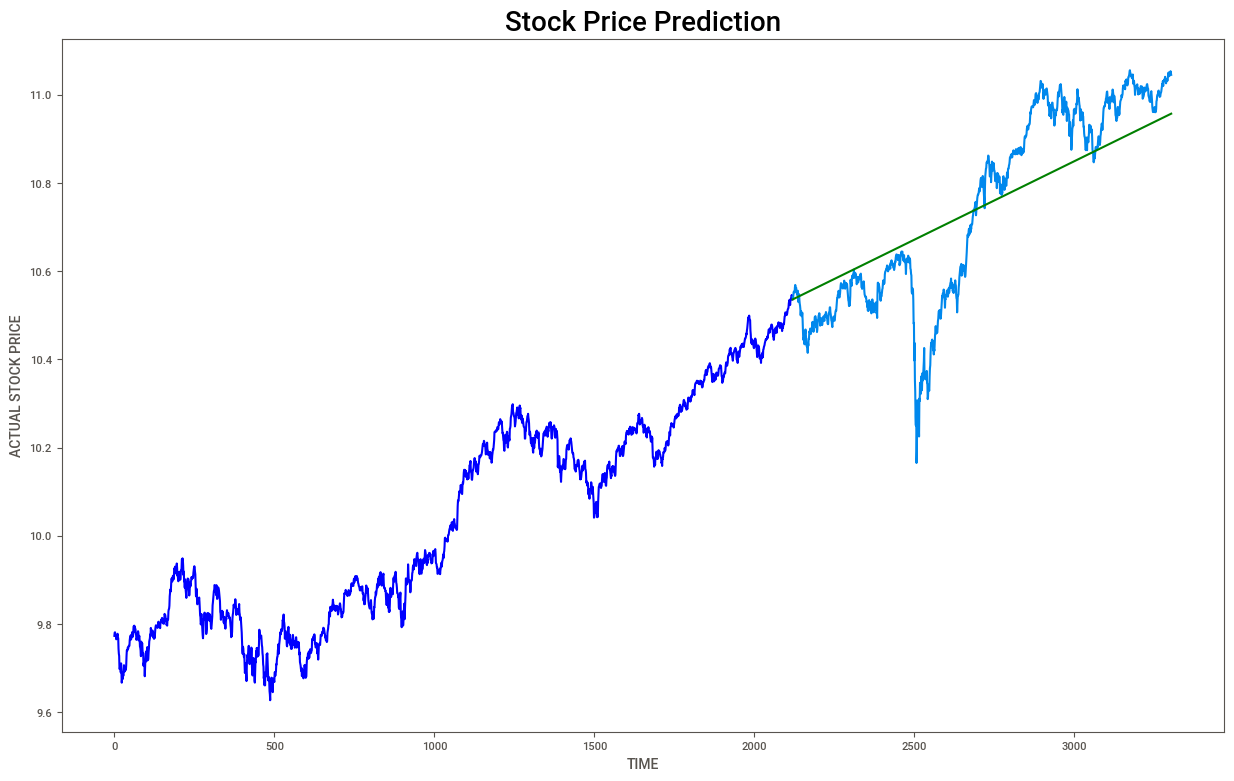

In [52]:
plt.figure(figsize=(15,9))
plt.plot(train_log,label='Train',color='blue')
plt.plot(test_log,label="Test")
plt.plot(predictions,color='green' ,label="Prediction")
plt.title("Stock Price Prediction",fontsize=20)
plt.xlabel("TIME")
plt.ylabel("ACTUAL STOCK PRICE")

In [53]:
#RMSE of ARIMA Model
rmse = np.sqrt(mean_squared_error(test_log,predictions))
print("The Root mean squared error is : ",rmse)

The Root mean squared error is :  0.1243956066028924


###Building the Hybrid Model

####Normalizing the Data

In [54]:
# Merging 'news' and 'stock' into one dataframe
merger=pd.merge(news,stock,how='inner',on='Date')
merger.sample(10)

,News,Date,Subjectivity,Polarity,Compound,Negative,Neutral,Positive,Open,High,Low,Close,Volume
914,Delhi gang rape Case diary Live blog Death p...,2013-09-13,0.429690,0.094660,-0.9999,0.177,0.701,0.122,19744.539062,19899.369141,19675.679688,19732.759766,10600
497,KBC winner Sushil Kumar to be a part of Britis...,2012-01-04,0.382935,0.045989,-0.9995,0.128,0.773,0.099,15967.490234,16004.690430,15822.320312,15882.639648,17800
1602,5 never to be said things during a fight How t...,2016-07-14,0.378512,0.094521,-0.9998,0.152,0.734,0.114,27857.800781,27967.769531,27763.150391,27942.109375,10500
2975,A zine festival that brings together the best ...,2022-02-10,0.370260,0.062670,-0.9999,0.170,0.746,0.085,58810.531250,59060.238281,58332.281250,58926.031250,6700
331,Smart ways to get a cute guy s attention Albie...,2011-05-03,0.384980,0.072736,-0.9999,0.177,0.719,0.103,18979.310547,19024.949219,18502.419922,18534.689453,13400
326,Kailash credits Lord Shiva for success Dad not...,2011-04-26,0.414547,0.049436,-0.9999,0.163,0.726,0.111,19596.320312,19626.130859,19306.919922,19545.349609,11600
1889,Sex positions you most likely haven t heard ab...,2017-09-12,0.419574,0.068008,-0.9998,0.148,0.746,0.105,32029.150391,32172.460938,31950.240234,32158.660156,7000
1133,7 Day flat belly diet plan How to boost your m...,2014-08-05,0.397189,0.051683,-0.9999,0.156,0.761,0.083,25817.839844,25928.320312,25562.359375,25908.009766,8800
2513,Cook extra meals for needy politicians appeal ...,2020-03-31,0.379149,0.042751,-0.9998,0.141,0.781,0.078,29294.939453,29770.880859,28667.359375,29468.490234,26400
396,Armani to kit out Italian Olympic team 7 Googl...,2011-08-02,0.417076,0.081401,-0.9995,0.144,0.744,0.112,18283.550781,18283.550781,18037.869141,18109.890625,11000


In [55]:
# Remove all the the columns that are not needed for Building the model
final_df=merger.drop(['Date','News','Open','Volume','High','Low'], axis=1)
final_df

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive,Close
0,0.453813,0.046573,-0.9995,0.156,0.738,0.105,17558.730469
1,0.414059,0.009239,-0.9996,0.145,0.774,0.080,17686.240234
2,0.432560,0.051819,-0.9996,0.155,0.746,0.099,17701.130859
3,0.406031,0.041903,-0.9997,0.174,0.718,0.107,17615.720703
4,0.379388,0.029047,-0.9999,0.178,0.723,0.099,17540.289062
...,...,...,...,...,...,...,...
3004,0.367225,-0.003859,-1.0000,0.182,0.743,0.075,57362.199219
3005,0.381673,0.058309,-0.9999,0.159,0.740,0.102,57593.488281
3006,0.400425,0.091291,-0.9999,0.158,0.759,0.084,57943.648438
3007,0.340023,0.039476,-0.9999,0.153,0.773,0.073,58683.988281


In [56]:
df=pd.DataFrame(MinMaxScaler().fit_transform(final_df))
df.columns=final_df.columns
df

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive,Close
0,0.750753,0.330825,0.00025,0.507143,0.388060,0.436975,0.051162
1,0.530624,0.111042,0.00020,0.428571,0.567164,0.226891,0.053899
2,0.633071,0.361706,0.00020,0.500000,0.427861,0.386555,0.054218
3,0.486171,0.303330,0.00015,0.635714,0.288557,0.453782,0.052385
4,0.338646,0.227652,0.00005,0.664286,0.313433,0.386555,0.050766
...,...,...,...,...,...,...,...
3004,0.271297,0.033931,0.00000,0.692857,0.412935,0.184874,0.905487
3005,0.351296,0.399912,0.00005,0.528571,0.398010,0.411765,0.910452
3006,0.455132,0.594079,0.00005,0.521429,0.492537,0.260504,0.917967
3007,0.120671,0.289045,0.00005,0.485714,0.562189,0.168067,0.933858


#### Spliting Data into Train and Test

In [57]:
X = df.drop('Close', axis = 1) # Features Dataframe
y = df['Close'] # Target Vector

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [59]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2407, 6), (602, 6), (2407,), (602,))

#### Different Models

In [60]:
# Decision Tree Regressor
dt = DecisionTreeRegressor()
dt.fit(X_train,y_train)
print('Decision Tree Regressor')
print("Train RMSE :",mean_squared_error(y_train,dt.predict(X_train),squared=False))
print("Test RMSE :",mean_squared_error(y_test,dt.predict(X_test),squared=False))
print("Train Score:",dt.score(X_train, y_train))
print("Test Score:",dt.score(X_test, y_test))

Decision Tree Regressor
Train RMSE : 0.0
Test RMSE : 0.26246175938443117
Train Score: 1.0
Test Score: -0.23419442387156564


In [61]:
# Random Forest Regressor
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
print('Random Forest Regressor')
print("Train RMSE :",mean_squared_error(y_train,rf.predict(X_train),squared=False))
print("Test RMSE :",mean_squared_error(y_test,rf.predict(X_test),squared=False))
print("Train Score:",rf.score(X_train, y_train))
print("Test Score:",rf.score(X_test, y_test))

Random Forest Regressor
Train RMSE : 0.0762663564063501
Test RMSE : 0.193807903028498
Train Score: 0.9040005811819225
Test Score: 0.32703190731391496


In [62]:
# XGB Regressor
xgb = xgboost.XGBRegressor()
xgb.fit(X_train,y_train)
print('XGB Regressor')
print("Train RMSE :",mean_squared_error(y_train,xgb.predict(X_train),squared=False))
print("Test RMSE :",mean_squared_error(y_test,xgb.predict(X_test),squared=False))
print("Train Score:",xgb.score(X_train, y_train))
print("Test Score:",xgb.score(X_test, y_test))

XGB Regressor
Train RMSE : 0.06640076571742629
Test RMSE : 0.2047941618965956
Train Score: 0.9272306020775367
Test Score: 0.2485732483703894


In [63]:
# LGBM Regressor
lgm = lightgbm.LGBMRegressor()
lgm.fit(X_train,y_train)
print('LGBM Regressor')
print("Train RMSE :",mean_squared_error(y_train,lgm.predict(X_train),squared=False))
print("Test RMSE :",mean_squared_error(y_test,lgm.predict(X_test),squared=False))
print("Train Score:",lgm.score(X_train, y_train))
print("Test Score:",lgm.score(X_test, y_test))

LGBM Regressor
Train RMSE : 0.13384603867344905
Test RMSE : 0.1949810666492274
Train Score: 0.7043256497763069
Test Score: 0.31885998873757826


In [64]:
# AdaBoost Regressor
xgb = AdaBoostRegressor()
xgb.fit(X_train,y_train)
print('AdaBoost Regressor')
print("Train RMSE :",mean_squared_error(y_train,xgb.predict(X_train),squared=False))
print("Test RMSE :",mean_squared_error(y_test,xgb.predict(X_test),squared=False))
print("Train Score:",xgb.score(X_train, y_train))
print("Test Score:",xgb.score(X_test, y_test))

AdaBoost Regressor
Train RMSE : 0.20872090169803875
Test RMSE : 0.2063197501997401
Train Score: 0.2809907275782896
Test Score: 0.2373362315162838


After evaluating all the models we can conclude that it is the Best Model as **Random Forest Regressor** has the least Root Mean Squared Error and the best Test Score.